# Implementing an End-to-End Automated Machine Learning Pipeline

This project focuses on creating an automated machine learning application that addresses a specific problem statement. The application will feature a complete pipeline for data preprocessing, model training, evaluation, and deployment. Emphasizing MLOps practices, this project aims to automate ML workflows effectively.

# Load the Dataset

In [1]:
import pandas as pd
import os

def load_imdb_dataset(dataset_dir):
    data = {'review': [], 'sentiment': []}
    for label in ['pos', 'neg']:
        sentiment_dir = os.path.join(dataset_dir, label)
        for filename in os.listdir(sentiment_dir):
            if filename.endswith('.txt'):
                with open(os.path.join(sentiment_dir, filename), 'r', encoding='utf-8') as file:
                    review = file.read()
                    data['review'].append(review)
                    data['sentiment'].append(1 if label == 'pos' else 0)
    return pd.DataFrame(data)

train_df = load_imdb_dataset('train')
test_df = load_imdb_dataset('test')


# Preprocess the Text Data

In [2]:
#!pip install transformers
#!pip install torch


In [3]:
from transformers import BertTokenizer
from torch.utils.data import DataLoader, TensorDataset
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_data(df, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []

    for review in df['review']:
        encoded = tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(df['sentiment'].values)

    return TensorDataset(input_ids, attention_masks, labels)

train_dataset = preprocess_data(train_df, tokenizer)
test_dataset = preprocess_data(test_df, tokenizer)


/Users/halasedki/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Text Cleaning and Normalization

In [4]:
import re
import pandas as pd
from nltk.corpus import stopwords

# Ensure stopwords are downloaded
import nltk
nltk.download('stopwords')

# Text cleaning function
def clean_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)  # Remove special characters
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])  # Remove stopwords
    return text

# Apply cleaning to the dataset
train_df['clean_review'] = train_df['review'].apply(clean_text)
test_df['clean_review'] = test_df['review'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/halasedki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Prepare the Data for Model Input

In [5]:
batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)


# Distribution of Sentiments

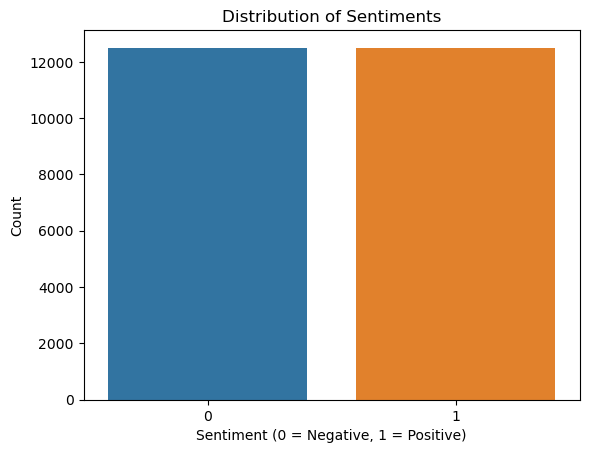

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of sentiments
sns.countplot(x='sentiment', data=train_df)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.show()


# Review Length Distribution

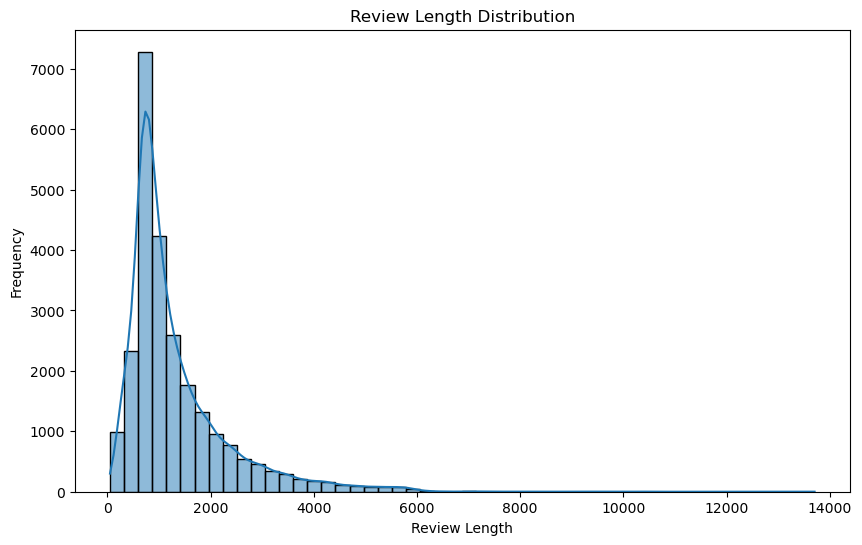

In [7]:
# Review length distribution
train_df['review_length'] = train_df['review'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(train_df['review_length'], bins=50, kde=True)
plt.title('Review Length Distribution')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()


# Word Clouds

In [8]:
!pip install wordcloud


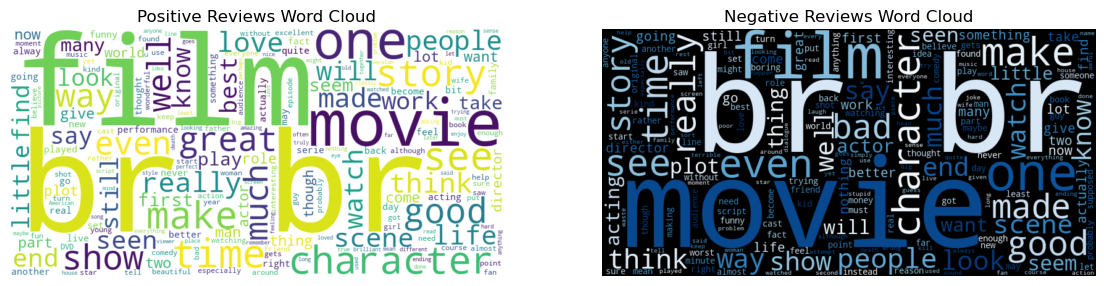

In [9]:
from wordcloud import WordCloud

# Generate word cloud for positive reviews
positive_reviews = ' '.join(train_df[train_df['sentiment'] == 1]['review'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

# Generate word cloud for negative reviews
negative_reviews = ' '.join(train_df[train_df['sentiment'] == 0]['review'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='black', colormap='Blues').generate(negative_reviews)

# Plot word clouds
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')

plt.show()


# Feature Engineering: Automated Feature Extraction and Selection

# Feature Extraction

Extract features such as text length, word count, and TF-IDF vectors.

In [10]:
# Feature extraction: Text length and word count
train_df['text_length'] = train_df['clean_review'].apply(len)
train_df['word_count'] = train_df['clean_review'].apply(lambda x: len(x.split()))

test_df['text_length'] = test_df['clean_review'].apply(len)
test_df['word_count'] = test_df['clean_review'].apply(lambda x: len(x.split()))


# TF-IDF Vectors

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)

train_tfidf = tfidf.fit_transform(train_df['clean_review'])
test_tfidf = tfidf.transform(test_df['clean_review'])


# Feature Selection

In [12]:
from sklearn.feature_selection import mutual_info_classif

# Feature selection using mutual information
mi = mutual_info_classif(train_tfidf, train_df['sentiment'], discrete_features=True)
mi_scores = pd.Series(mi, index=tfidf.get_feature_names_out()).sort_values(ascending=False)

# Select top features based on mutual information score
top_features = mi_scores.head(20).index.tolist()
print(top_features)


/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

['movie', 'one', 'film', 'like', 'good', 'time', 'even', 'would', 'see', 'story', 'really', 'well', 'much', 'get', 'also', 'great', 'first', 'made', 'bad', 'people']


/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/halasedki/anaconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

# Combining Features into a DataFrame

In [13]:
import numpy as np

# Combine features into a DataFrame
train_features = pd.DataFrame(train_tfidf.toarray(), columns=tfidf.get_feature_names_out())
train_features['text_length'] = train_df['text_length']
train_features['word_count'] = train_df['word_count']

test_features = pd.DataFrame(test_tfidf.toarray(), columns=tfidf.get_feature_names_out())
test_features['text_length'] = test_df['text_length']
test_features['word_count'] = test_df['word_count']


# Final Model Training

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_features, train_df['sentiment'], test_size=0.2, random_state=42)

# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy}')
print(classification_report(y_val, y_pred))


Validation Accuracy: 0.8782
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      2485
           1       0.87      0.90      0.88      2515

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



# Model Integration

In [15]:
!pip install transformers


In [16]:
from transformers import BertForSequenceClassification, AdamW, BertTokenizer

# Load the BERT model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


/Users/halasedki/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Prepare Data for BERT

In [17]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

# Tokenize and encode the data
def encode_data(text_list, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []

    for text in text_list:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_input_ids, train_attention_masks = encode_data(train_df['review'].tolist(), tokenizer)
test_input_ids, test_attention_masks = encode_data(test_df['review'].tolist(), tokenizer)

train_labels = torch.tensor(train_df['sentiment'].values)
test_labels = torch.tensor(test_df['sentiment'].values)

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)


# Fine-tune the BERT Model

In [18]:
from transformers import get_linear_schedule_with_warmup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 5  # 5 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

for epoch in range(5):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        model.zero_grad()

        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}, Loss: {avg_train_loss}')


/Users/halasedki/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 0.33286497348447897
Epoch 2, Loss: 0.1959410987584792
Epoch 3, Loss: 0.10962922433974778
Epoch 4, Loss: 0.08026019508636002
Epoch 5, Loss: 0.08199562582656589


# Evaluate the Model

In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

model.eval()
predictions, true_labels = [], []

for batch in test_dataloader:
    b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs.logits
    predictions.append(logits.argmax(dim=-1).cpu().numpy())
    true_labels.append(b_labels.cpu().numpy())

predictions = np.concatenate(predictions)
true_labels = np.concatenate(true_labels)

accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

print(f'Test Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Test Accuracy: 0.8906
Precision: 0.8837538316434803
Recall: 0.89952
F1 Score: 0.8915672203940849


# Save the Model and Tokenizer

In [20]:
import os
from transformers import BertForSequenceClassification, BertTokenizer

# Define the model save path
model_save_path = './model_save/'

# Create the directory if it doesn't exist
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

# Save the fine-tuned model and tokenizer
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f'Model and tokenizer saved to {model_save_path}')


Model and tokenizer saved to ./model_save/
